In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')

In [3]:



dataset_path = "/content/drive/MyDrive/train"

imagesize = 256
batchsize = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(imagesize, imagesize),
    batch_size=batchsize
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 9307 files belonging to 3 classes.
Classes: ['Potato Early blight', 'Potato Healthy', 'Potato Late blight']


In [4]:
class_names = dataset.class_names
print("Classes:", class_names)

Classes: ['Potato Early blight', 'Potato Healthy', 'Potato Late blight']


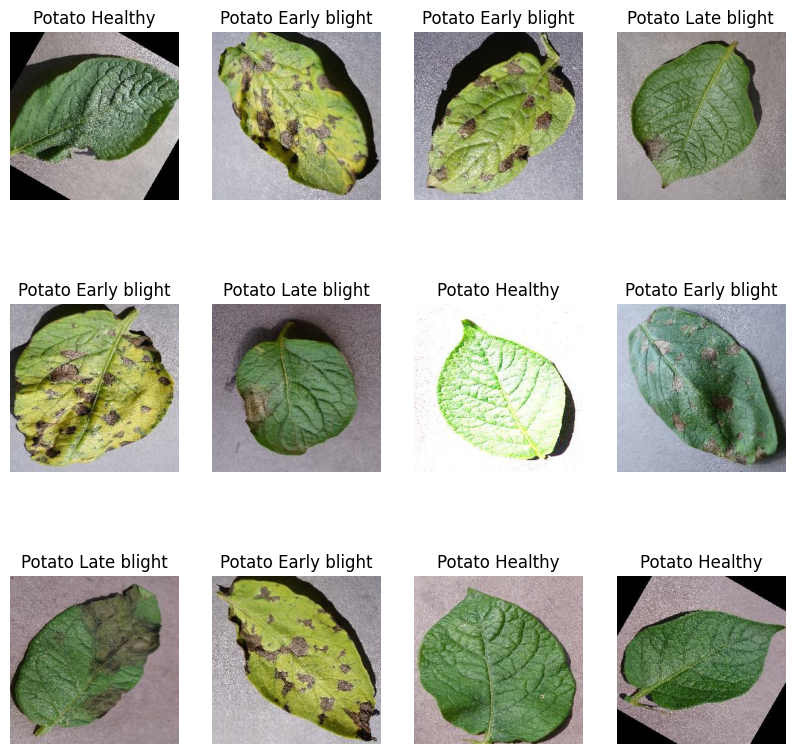

In [5]:
import matplotlib.pyplot as plt
for image_batch, labels_batch in dataset.take(1):
 plt.figure(figsize=(10, 10))
 for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.title(class_names[labels_batch[i]])
  plt.axis("off")

In [6]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
 dataset_size = len(dataset)
 train_size = int(train_ratio * dataset_size)
 val_size = int(val_ratio * dataset_size)
 test_size = dataset_size - train_size - val_size

 train_ds = dataset.take(train_size)
 val_ds = dataset.skip(train_size).take(val_size)
 test_ds = dataset.skip(train_size + val_size)

 return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = split_dataset(dataset)
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 232, Validation size: 29, Test size: 30


In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(imagesize, imagesize),
    layers.Rescaling(1./255),
])

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2)  # If this causes an error, replace with tf.image.adjust_brightness
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [10]:
import os
imgsize = 64
features, labels = [], []
for image_batch, labels_batch in dataset.unbatch().take(4000):
 image = tf.image.resize(image_batch, (imgsize,imgsize)).numpy()
 features.append(image.flatten())
 labels.append(labels_batch.numpy())
features = np.array(features)
labels = np.array(labels)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", knn_acc)
print(classification_report(y_test,y_pred_knn))

KNN Accuracy: 0.7125
              precision    recall  f1-score   support

           0       0.99      0.52      0.68       451
           1       0.93      0.64      0.76       328
           2       0.56      0.98      0.71       421

    accuracy                           0.71      1200
   macro avg       0.83      0.71      0.72      1200
weighted avg       0.82      0.71      0.71      1200



In [13]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", dt_acc)
print(classification_report(y_test,y_pred_dt))

Decision Tree Accuracy: 0.765
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       451
           1       0.76      0.67      0.71       328
           2       0.71      0.76      0.73       421

    accuracy                           0.77      1200
   macro avg       0.76      0.76      0.76      1200
weighted avg       0.77      0.77      0.76      1200



In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_acc)
print(classification_report(y_test,y_pred_rf))

Random Forest Accuracy: 0.8658333333333333
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       451
           1       0.97      0.70      0.81       328
           2       0.79      0.92      0.85       421

    accuracy                           0.87      1200
   macro avg       0.88      0.85      0.86      1200
weighted avg       0.88      0.87      0.86      1200



In [15]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear',decision_function_shape='ovr', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", svm_acc)
print(classification_report(y_test,y_pred_svm))

SVM Accuracy: 0.8616666666666667
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       451
           1       0.85      0.73      0.79       328
           2       0.80      0.89      0.85       421

    accuracy                           0.86      1200
   macro avg       0.86      0.85      0.85      1200
weighted avg       0.86      0.86      0.86      1200



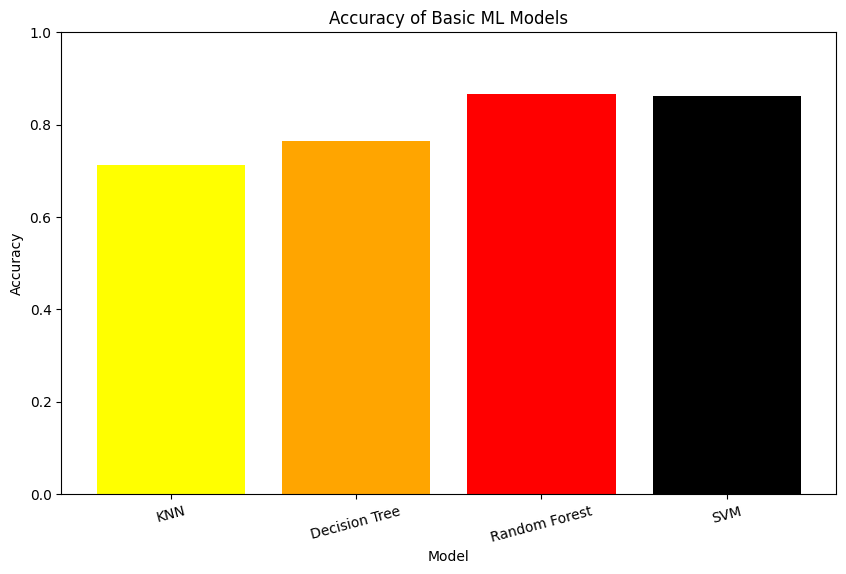

In [16]:
import matplotlib.pyplot as plt
model_names = ['KNN', 'Decision Tree', 'Random Forest', 'SVM']
accuracies = [knn_acc,
 dt_acc,
 rf_acc,
 svm_acc
 ]
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=[ 'yellow', 'orange', 'red', 'black'])
plt.title('Accuracy of Basic ML Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()

In [17]:
channels=3
input_shape = (batchsize, imagesize,imagesize, channels)
n_classes = 3
model = models.Sequential([
 resize_and_rescale,
 layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Flatten(),
 layers.Dense(64, activation='relu'),
 layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
 optimizer='adam',
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
 metrics=['accuracy']
)

In [20]:
history = model.fit(
 train_ds,
 batch_size=batchsize,
 validation_data=val_ds,
 verbose=1,
 epochs=14,
)


Epoch 1/14
232/232 ━━━━━━━━━━━━━━━━━━━━ 219s 780ms/step - accuracy: 0.5553 - loss: 0.8655 - val_accuracy: 0.7026 - val_loss: 1.4782
Epoch 2/14
232/232 ━━━━━━━━━━━━━━━━━━━━ 137s 588ms/step - accuracy: 0.9285 - loss: 0.1967 - val_accuracy: 0.8459 - val_loss: 0.5694
Epoch 3/14
232/232 ━━━━━━━━━━━━━━━━━━━━ 140s 603ms/step - accuracy: 0.9628 - loss: 0.1107 - val_accuracy: 0.9515 - val_loss: 0.1315
Epoch 4/14
232/232 ━━━━━━━━━━━━━━━━━━━━ 143s 616ms/step - accuracy: 0.9692 - loss: 0.0898 - val_accuracy: 0.9364 - val_loss: 0.1846
Epoch 5/14
232/232 ━━━━━━━━━━━━━━━━━━━━ 142s 611ms/step - accuracy: 0.9755 - loss: 0.0742 - val_accuracy: 0.7672 - val_loss: 0.9837
Epoch 6/14
232/232 ━━━━━━━━━━━━━━━━━━━━ 141s 609ms/step - accuracy: 0.9826 - loss: 0.0551 - val_accuracy: 0.9030 - val_loss: 0.4489
Epoch 7/14
232/232 ━━━━━━━━━━━━━━━━━━━━ 134s 576ms/step - accuracy: 0.9836 - loss: 0.0496 - val_accuracy: 0.6239 - val_loss: 3.4471
Epoch 8/14
232/232 ━━━━━━━━━━━━━━━━━━━━ 135s 581ms/step - accuracy: 0.9799 -

In [21]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

# Print the accuracy
print("CNN Accuracy:", accuracy)

30/30 ━━━━━━━━━━━━━━━━━━━━ 263s 125ms/step - accuracy: 0.9443 - loss: 0.2564
CNN Accuracy: 0.944502592086792


In [22]:
# Define the save path
save_path = '/content/drive/MyDrive/my_cnn_model.h5'  # Replace with your desired path

# Save the model
model.save(save_path)